# Exploratory Data Analysis

Data analysis on Figma design elements and their corresponding HTML tags:
- Understand data distributions
- Identify patterns in design-to-HTML mapping
- Clean and preprocess the dataset
- Analyze feature correlations
- Visualize key insights

## Steps
1. Load and clean dataset (remove invalid tags, handle missing data) => used in case of old Dataset Generator
2. Normalize HTML tags into standardized categories => Fewer Labels for the model to train on then use sub models for each specification
3. Encode and scale features for analysis
4. Visualize tag distributions
5. Analyze correlations between features
6. Evaluate whether PCA is useful for dimensionality reduction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Data Loading and Initial Cleaning

In [2]:
def load_and_clean_data(filepath):
    """Load Figma dataset and clean it

    Args:
        filepath : Path to the CSV file containing Figma jsons

    Returns:
        Cleaned dataset with invalid HTML tags removed or replaced

    Steps:
        - Removes tags with special characters or uncommon elements using regex
        - Replaces invalid sibling and child tags with 'DIV'
    """
    # Load dataset
    df = pd.read_csv(filepath)

    # Regex pattern for invalid tags => (special characters, uncommon elements) => For old data generator
    invalid_pattern = (
        r'[-:]|\b(CNX|ADDRESS|ASIDE|CANVAS|CITE|DD|DL|DT|ICON|S|VECTOR|DEL|LEGEND|'
        r'BDI|LOGO|OBJECT|OPTGROUP|CENTER|CODE|BLOCKQUOTE|FRONT|Q|IFRAME|SEARCH|'
        r'DETAILS|FIELDSET|SLOT|AD|ADSLOT|AUDIO|BLINK|BOLD|COL|COLGROUP|COMMENTS|'
        r'DATA|DIALOG|EMBED|EMPHASIS|FONT|H7|HGROUP|INS|INTERACTION|ITALIC|ITEMTEMPLATE|'
        r'MARK|MATH|MENU|MI|MN|MO|MROW|MSUP|NOBR|OFFER|OPTION|PATH|PROGRESS|STRIKE|'
        r'SWAL|TEXT|TFOOT|TITLE|TT|VAR|VEV|W|WBR|COUNTRY|ESI:INCLUDE|HTTPS:|LOGIN|'
        r'NOCSRIPT|PERSONAL|STONG|CONTENT|DELIVERY|LEFT|MSUBSUP|KBD|ROOT|PARAGRAPH|'
        r'BE|AI2SVELTEWRAP|BANNER|PHOTO1)\b'
    )

    # Remove rows with invalid tags
    df = df[~df['tag'].str.contains(invalid_pattern, regex=True, na=False)]

    # Replace invalid tags in sibling and child columns with 'DIV'
    for col in ['prev_sibling_html_tag', 'child_1_html_tag', 'child_2_html_tag']:
        df[col] = np.where(
            df[col].str.contains(invalid_pattern, regex=True, na=False),
            'DIV',
            df[col]
        )

    return df

df = load_and_clean_data('new_figma_dataset7.csv')

C:\Users\AOZ\AppData\Local\Temp\ipykernel_12604\1190986895.py:30: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df['tag'].str.contains(invalid_pattern, regex=True, na=False)]
C:\Users\AOZ\AppData\Local\Temp\ipykernel_12604\1190986895.py:35: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[col].str.contains(invalid_pattern, regex=True, na=False),


## Tag Normalization and Mapping

In [ ]:
def normalize_tags(df):
    """Normalize HTML tags => reduce their numbers by clustering

    Args:
        df : Input dataset with HTML tag columns

    Returns:
        Dataset with normalized tags => (H1->P, ARTICLE->DIV)

    Steps:
        - cluster specific HTML tags to general categories => (DIV, P, INPUT, BUTTON, SVG)
        - Handles special cases (SPAN with RECTANGLE or GROUP types)
        - Standardizes tag case to uppercase
        - Filters dataset to include only standardized tags => More checking
    """
    # Define mapping to cluster tags to general categories
    tag_mapping = {
        # Structural elements -> DIV
        'ARTICLE': 'DIV', 'DIV': 'DIV', 'FIGURE': 'DIV', 'FOOTER': 'DIV',
        'HEADER': 'DIV', 'NAV': 'DIV', 'MAIN': 'DIV', 'BODY': 'DIV',
        'FORM': 'DIV', 'OL': 'DIV', 'UL': 'DIV', 'TABLE': 'DIV',
        'THEAD': 'DIV', 'TBODY': 'DIV', 'SECTION': 'DIV',

        # Text elements -> P
        'H1': 'P', 'H2': 'P', 'H3': 'P', 'H4': 'P', 'H5': 'P', 'H6': 'P',
        'SUP': 'P', 'SUB': 'P', 'BIG': 'P', 'P': 'P', 'CAPTION': 'P',
        'FIGCAPTION': 'P', 'B': 'P', 'EM': 'P', 'I': 'P', 'TD': 'P',
        'TH': 'P', 'TR': 'P', 'PRE': 'P', 'U': 'P', 'TIME': 'P',
        'TXT': 'P', 'ABBR': 'P', 'SMALL': 'P', 'STRONG': 'P',
        'SUMMARY': 'P', 'SPAN': 'P', 'LABEL': 'P', 'LI': 'P',

        # Media elements -> IMG
        'PICTURE': 'IMG', 'VIDEO': 'IMG',

        # Input elements -> INPUT
        'SELECT': 'INPUT', 'TEXTAREA': 'INPUT',

        # Vector graphics -> SVG
        'VECTOR': 'SVG',

        # Buttons -> BUTTON
        'BUTTON': 'BUTTON'
    }

    # Special case: SPAN with RECTANGLE or GROUP type becomes DIV
    df.loc[(df['tag'] == 'SPAN') & (df['type'].isin(['RECTANGLE', 'GROUP'])), 'tag'] = 'DIV'

    # Clean children tags => replace tags with hyphens
    children_cols = ['child_1_html_tag', 'child_2_html_tag']
    for col in children_cols:
        df[col] = df[col].apply(lambda x: 'DIV' if isinstance(x, str) and '-' in x else x)

    # Standardize tag case to uppercase
    tag_cols = ['tag', 'prev_sibling_html_tag', 'child_1_html_tag', 'child_2_html_tag']
    for col in tag_cols:
        df[col] = df[col].str.upper()

    # Apply tag mapping
    for col in tag_cols:
        df[col] = df[col].replace(tag_mapping)

    # Filter to keep only standardized tags
    df = df[df['tag'].isin(tag_mapping.values())]

    return df

# Normalize tags and display unique tags
df = normalize_tags(df)
print('Standardized tags:', df['tag'].unique())

Standardized tags: ['DIV' 'P' 'INPUT' 'BUTTON' 'SVG']


## Data Exploration and Visualization

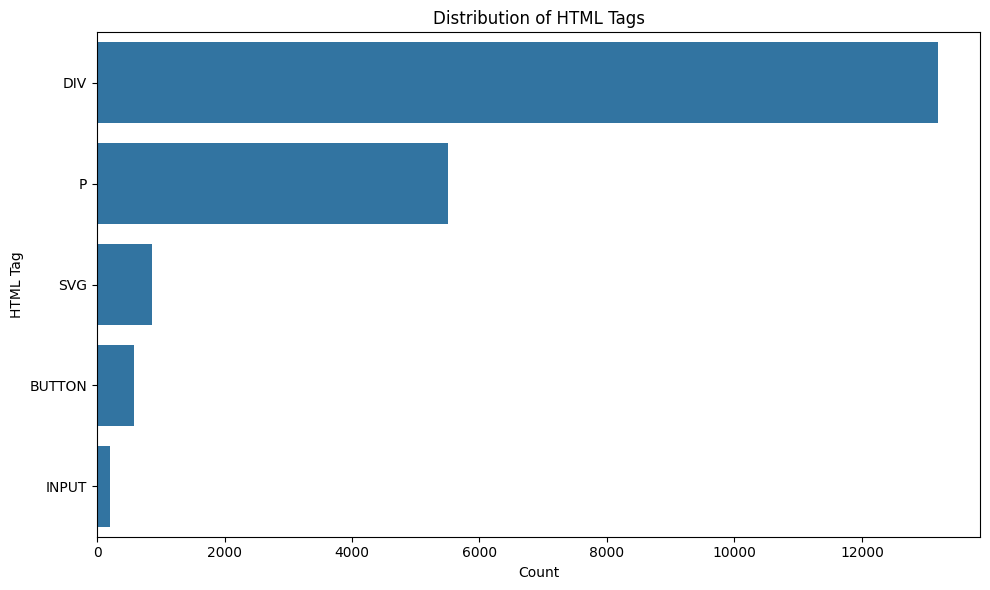

In [4]:
def plot_tag_distribution(df):
    """Visualize the distribution of HTML tags in the dataset

    Args:
        df : Dataset containing HTML tags

    Steps:
        - Creates a plot showing tag counts
        - order tags by frequency
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, y='tag', order=df['tag'].value_counts().index)
    plt.title('Distribution of HTML Tags')
    plt.xlabel('Count')
    plt.ylabel('HTML Tag')
    plt.tight_layout()
    plt.show()

# Plot tag distribution
plot_tag_distribution(df)

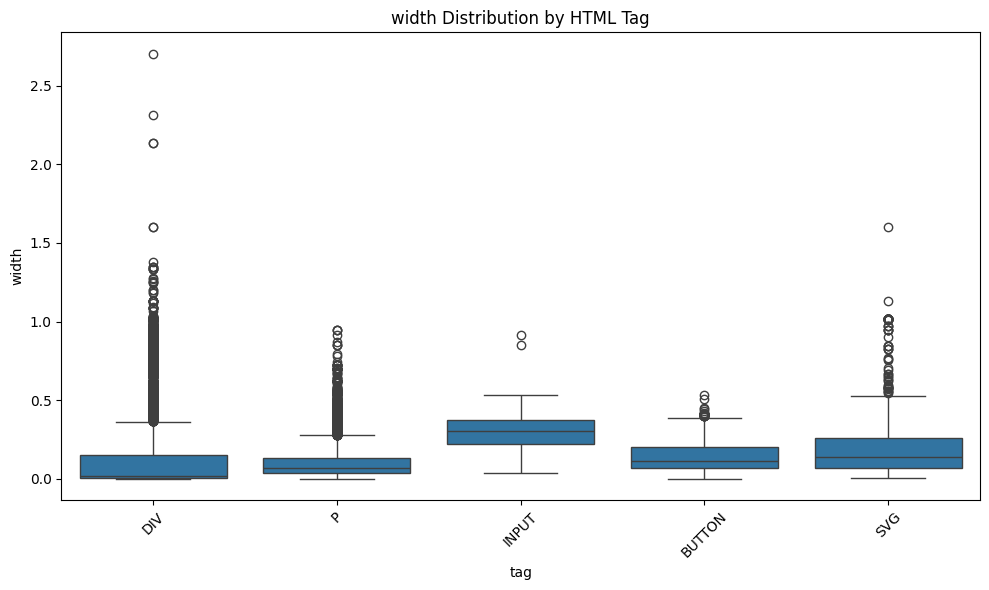

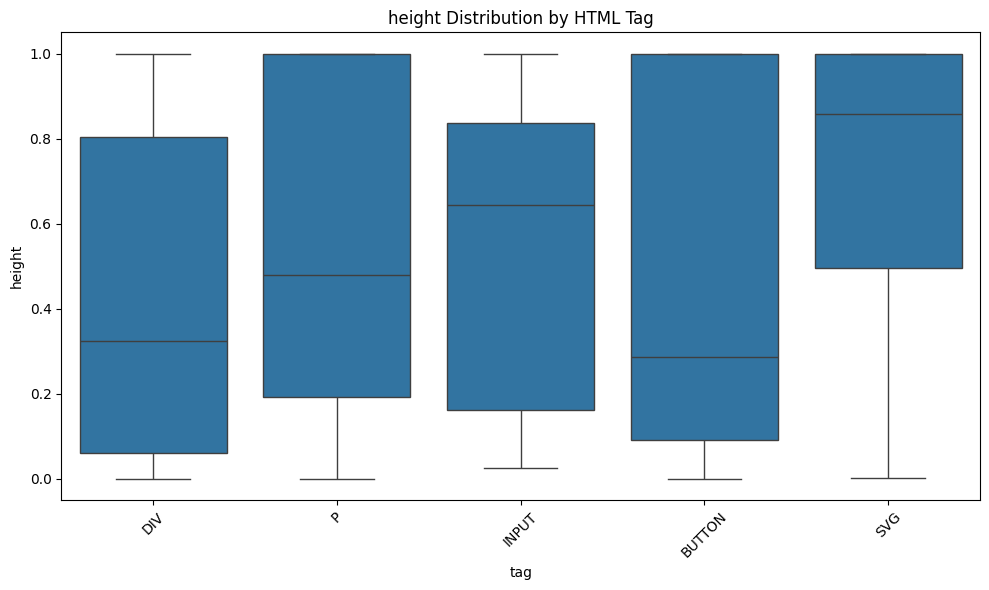

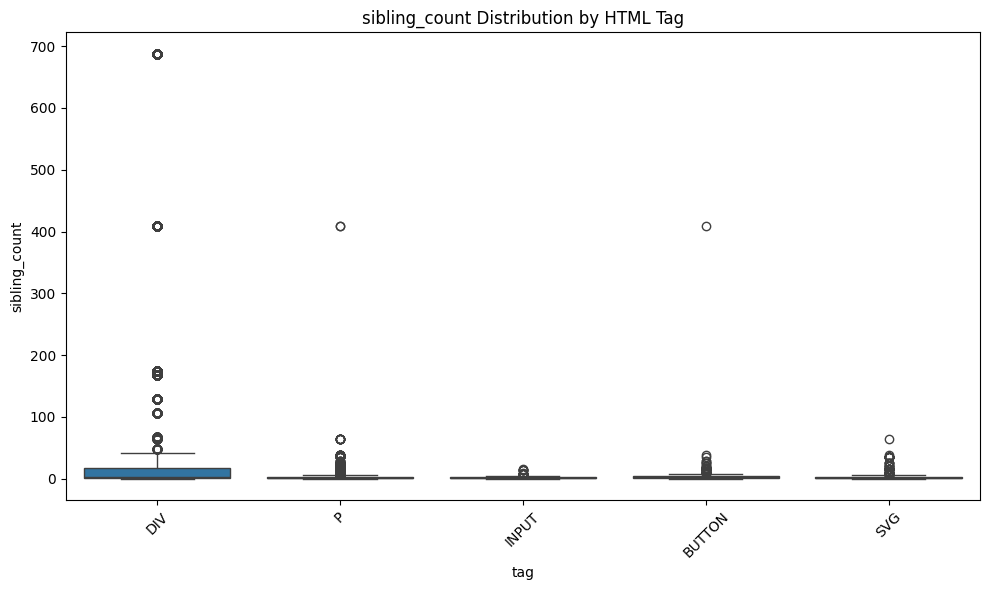

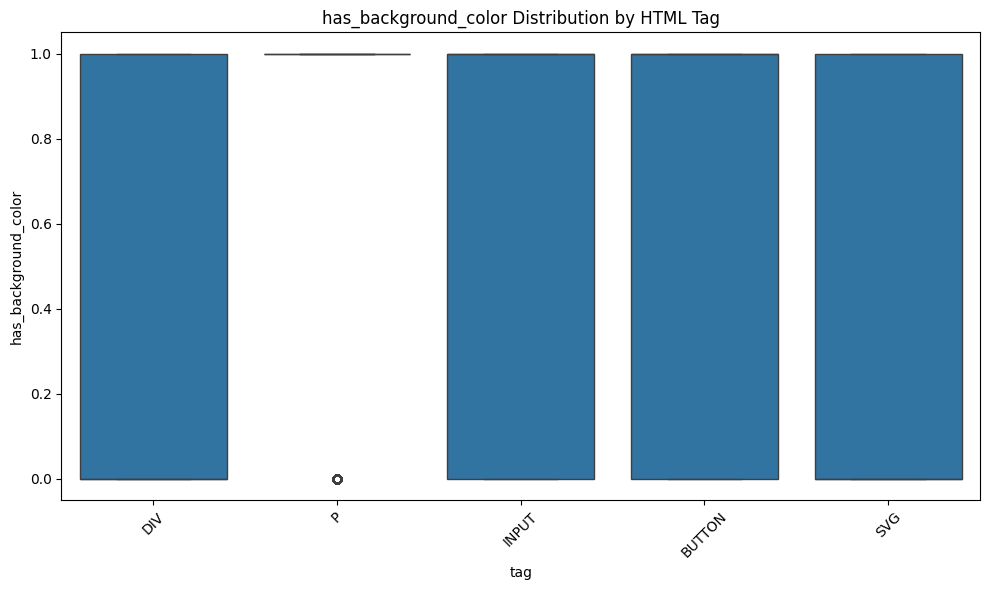

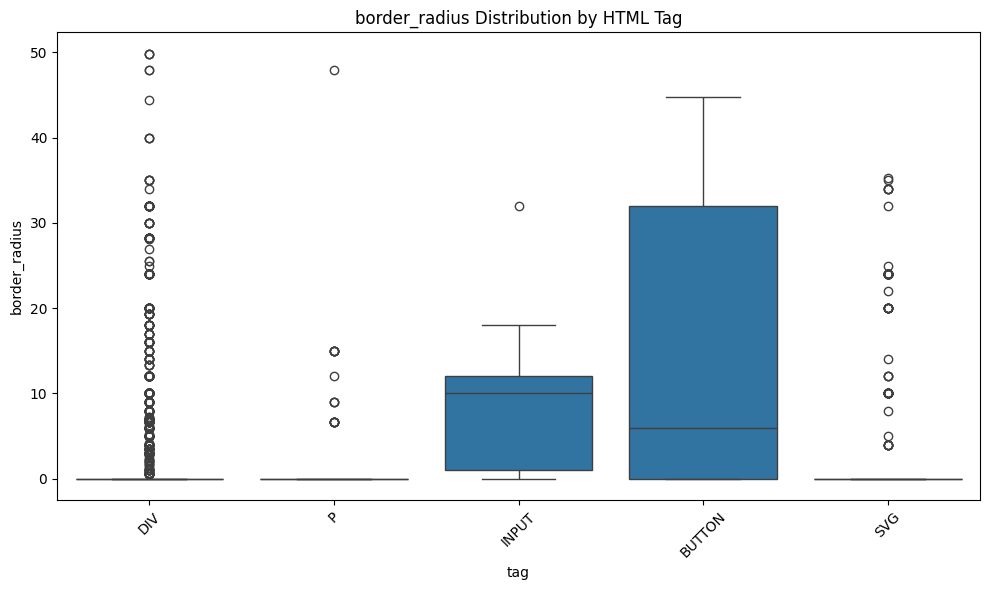

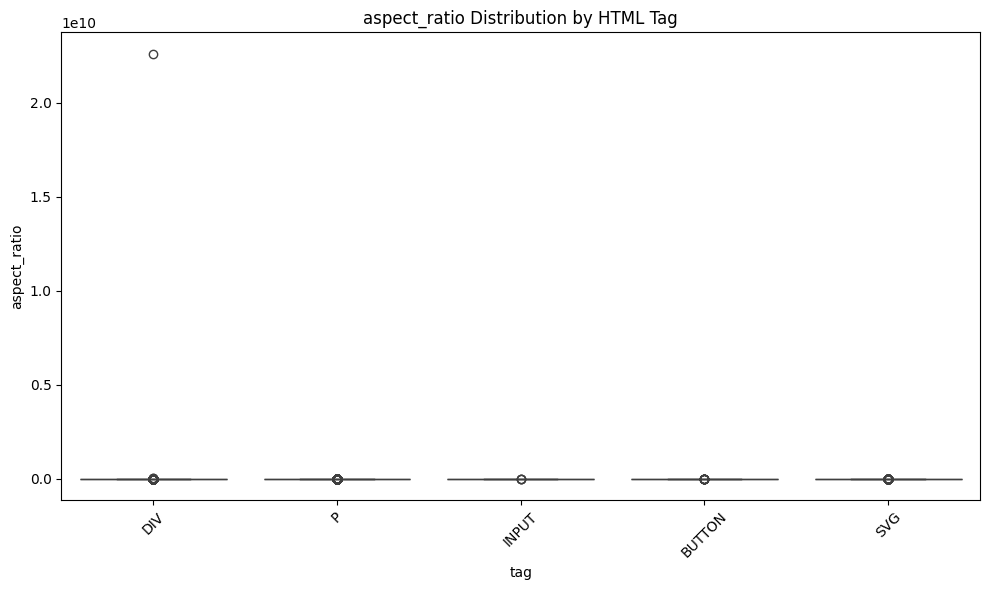

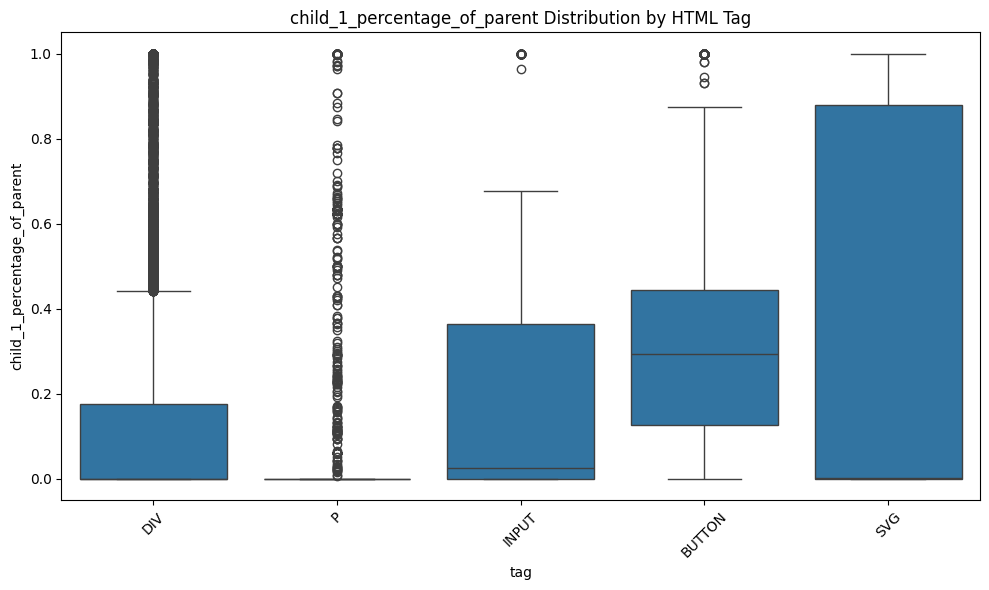

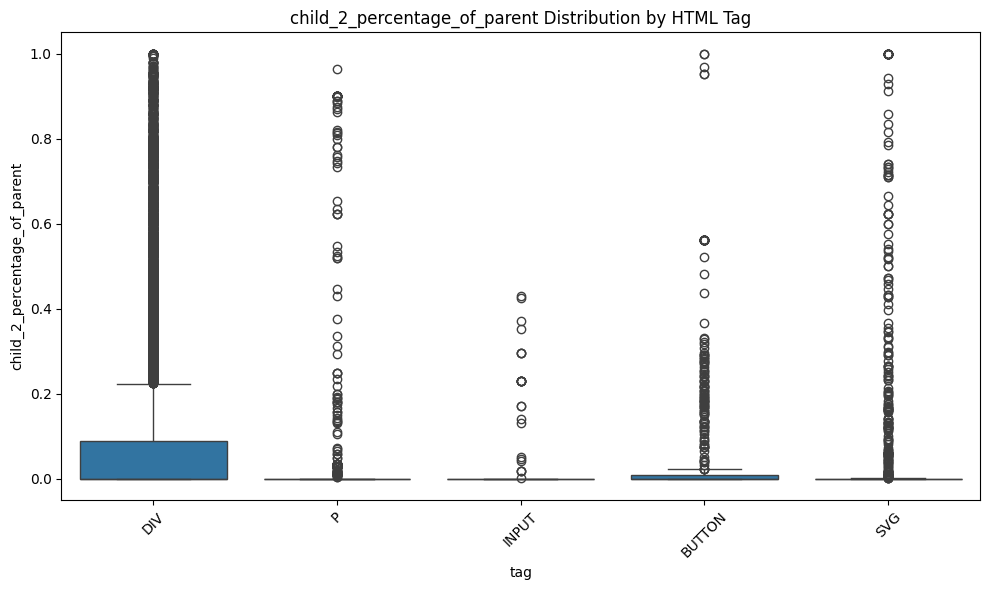

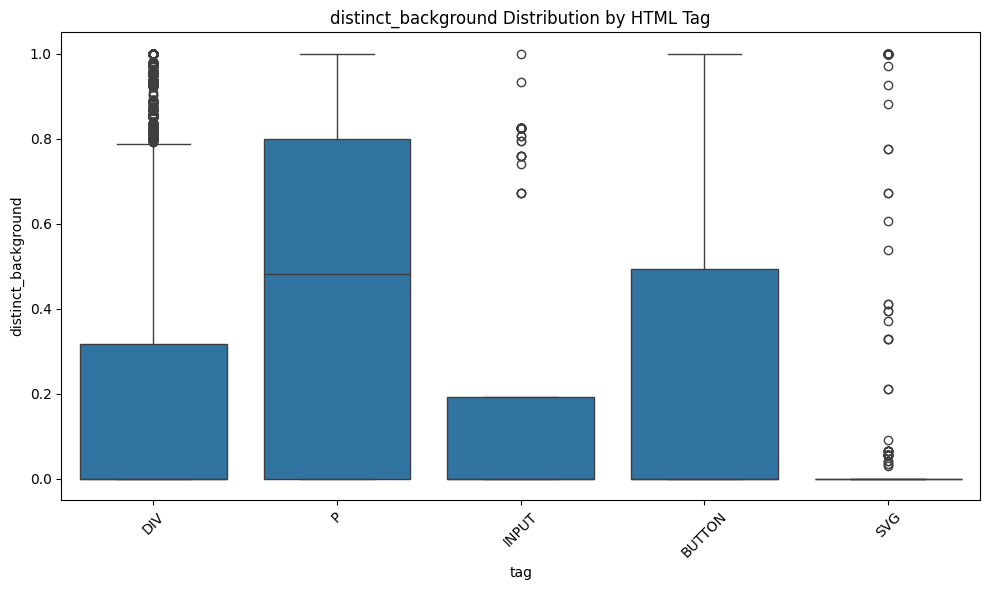

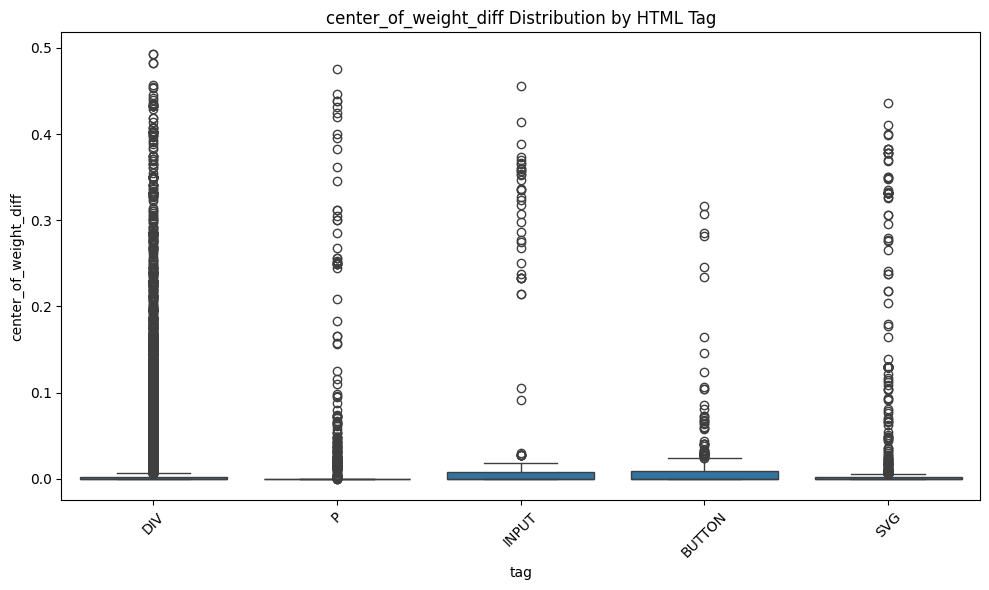

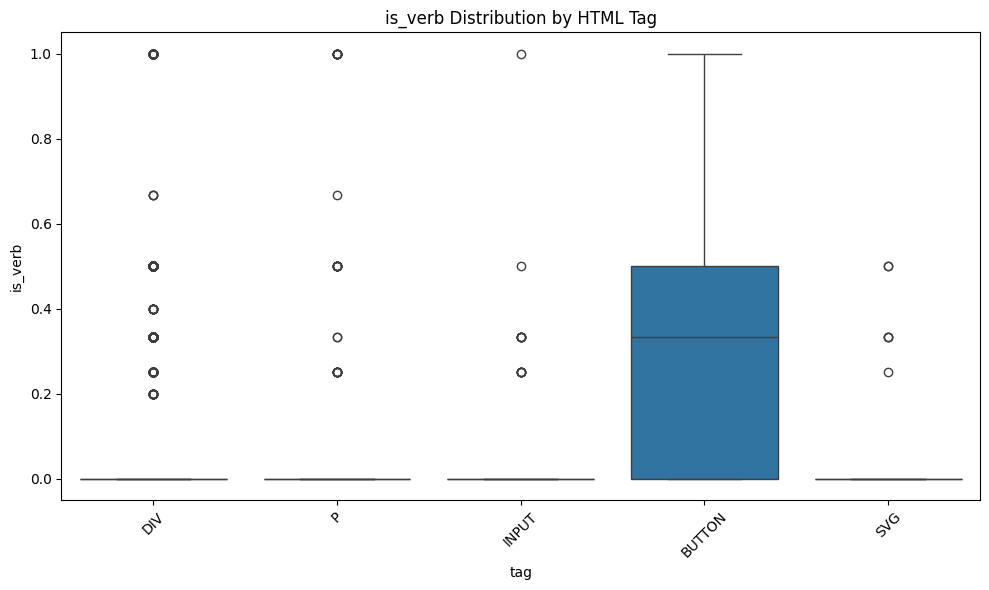

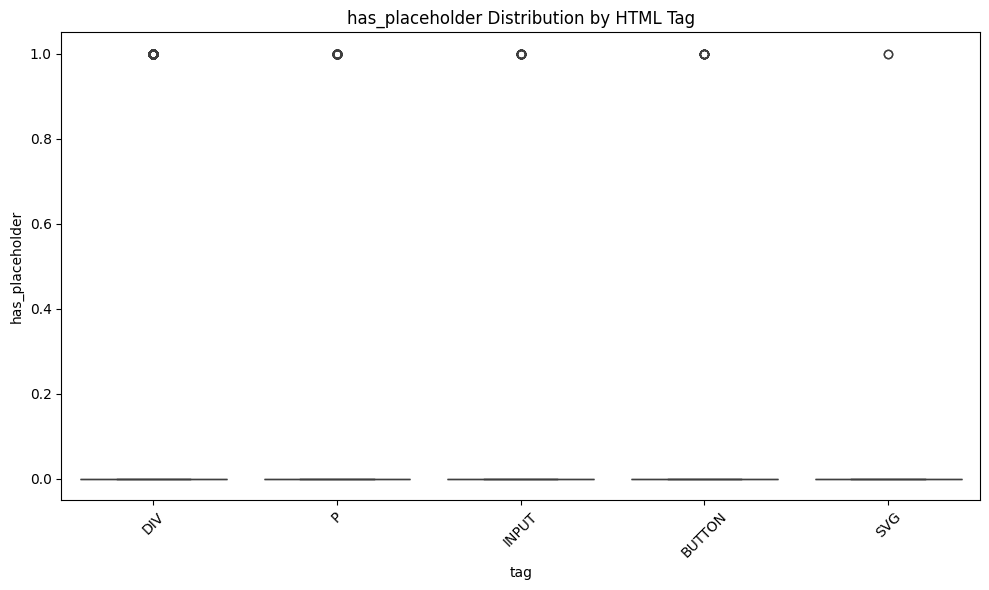

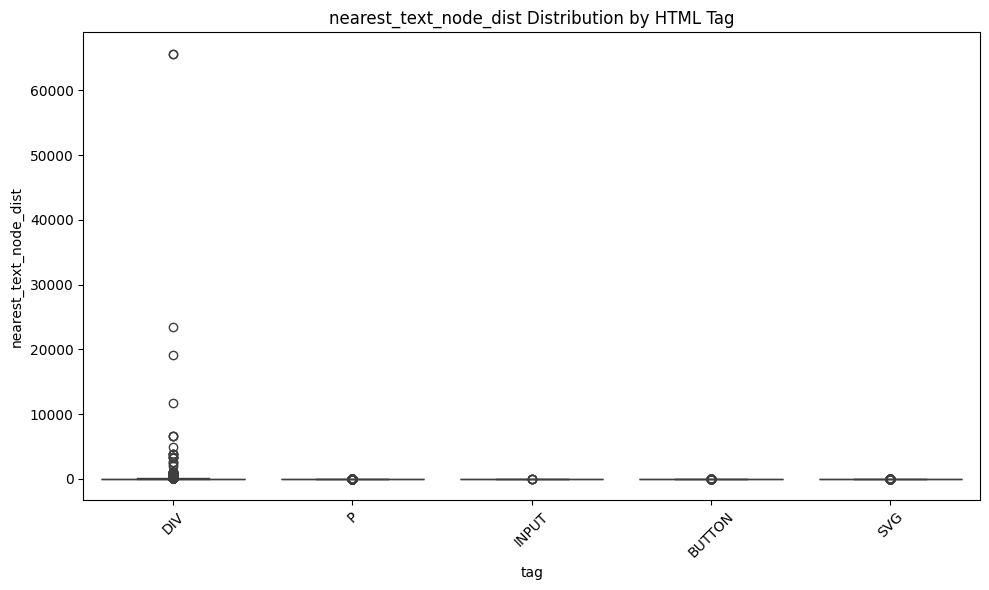

In [5]:
def plot_feature_distributions(df, features, target = 'tag'):
    """Plot distributions of features by HTML tag

    Args:
        df : Dataset containing features
        features : List of feature column names
        target : Target column name to plot against => (x axis)
    """
    for feature in features:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x=target, y=feature)
        plt.title(f'{feature} Distribution by HTML Tag')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Select numerical features for visualization
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
plot_feature_distributions(df, numerical_cols)

## Feature Processing

In [6]:
# Prepare features for analysis
label_column = 'tag'
categorical_cols = ['type', 'prev_sibling_html_tag', 'child_1_html_tag', 'child_2_html_tag', 'parent_tag_html']
features = df.columns.difference([label_column])

# Encode categorical features using factorization
df_encoded = df.copy()
for col in features:
    if df[col].dtype == 'object':
        df_encoded[col], _ = pd.factorize(df[col])

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded[features])
y = df_encoded[label_column]

## Correlation Analysis

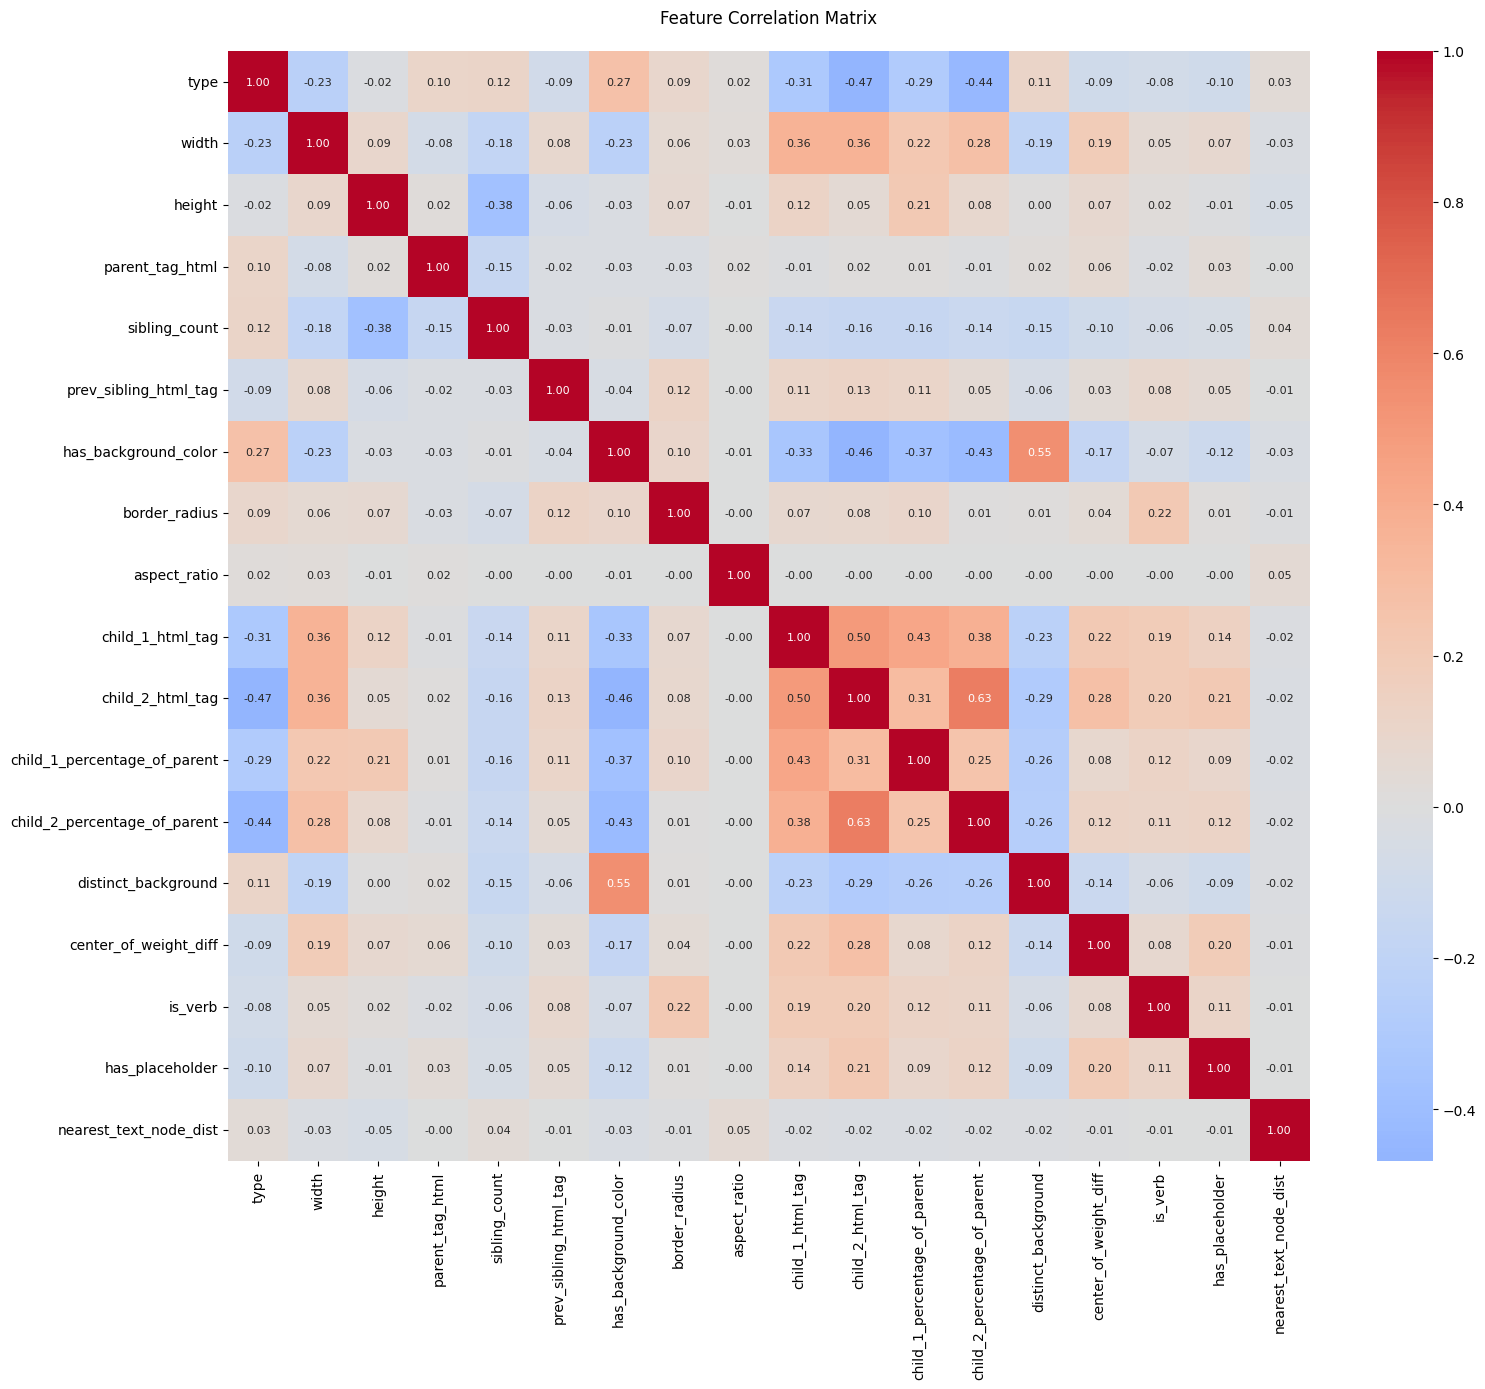

In [7]:
def plot_correlation_matrix(df, figsize = (16, 14)):
    """Plot a correlation matrix for numerical features

    Args:
        df : encoded dataset

    Steps:
        - Select numerical columns and fills missing values with 0
        - Displays a heatmap
    """
    # Select numerical columns
    numeric_df = df.select_dtypes(include=[np.number])
    # Handle missing values
    numeric_df = numeric_df.fillna(0)

    # Calculate correlation matrix
    corr_matrix = numeric_df.corr()

    # Plot heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        center=0,
        annot_kws={'size': 8}
    )
    plt.title('Feature Correlation Matrix', pad=20)
    plt.tight_layout()
    plt.show()

# Plot correlation matrix for encoded features
plot_correlation_matrix(df_encoded)

## Dimensionality Reduction with PCA

- Get how much variance is captured by PCA components
- Evaluate whether PCA is useful for dimensionality reduction

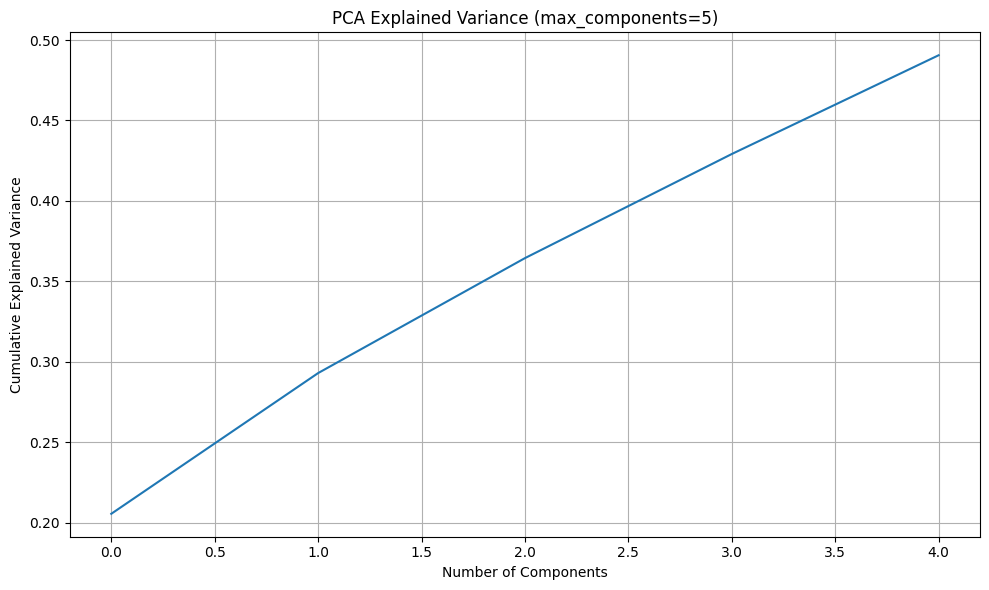

Cumulative explained variance for 5 components: 0.4905


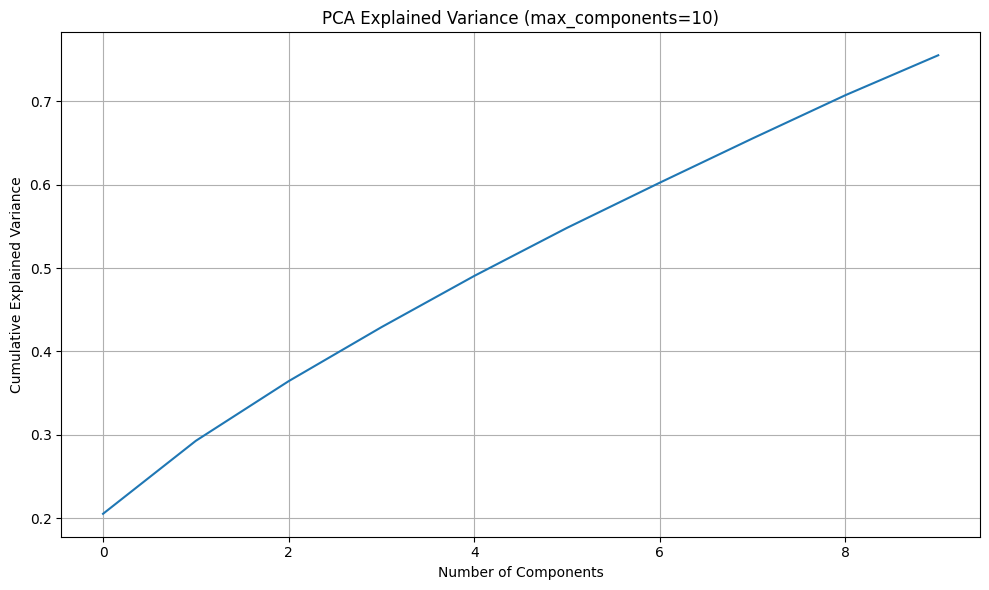

Cumulative explained variance for 10 components: 0.7550


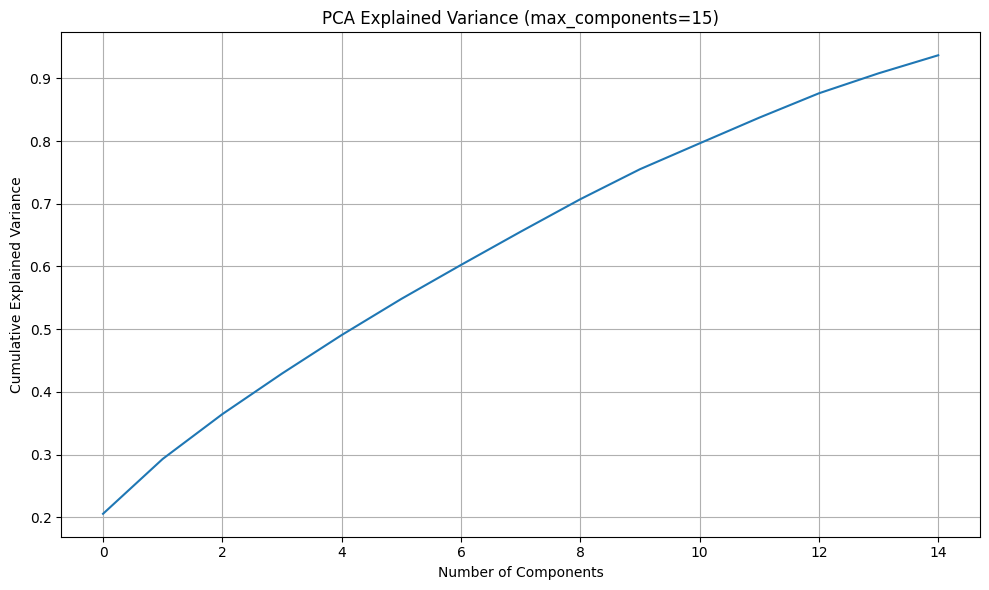

Cumulative explained variance for 15 components: 0.9368


In [ ]:
def plot_explained_variance(df_encoded, target = 'tag', number_of_components = [5, 10, 15], figsize = (10, 6)):
    """Plot cumulative explained variance for PCA components

    Args:
        df_encoded : Encoded figma dataset.
        target : Target column name to exclude from PCA
        number_of_components : List of # of PCA components to try
    """
    # Prepare features (exclude target)
    X = df_encoded.drop(columns=[target])

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Try different number of components
    for max_components in number_of_components:
        n_components = min(max_components, X_scaled.shape[1])
        pca = PCA(n_components=n_components)
        pca.fit(X_scaled)

        # Plot cumulative explained variance
        plt.figure(figsize=figsize)
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title(f'PCA Explained Variance (max_components={max_components})')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Print cumulative variance for the maximum number of components
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)[-1]
        print(f'Cumulative explained variance for {max_components} components: {cumulative_variance:.4f}')

# PCA with different number of components
plot_explained_variance(df_encoded)

## PCA Findings

- With 17 total features, achieving over 90% cumulative variance requires approximately 15 components suggesting PCA is less effective for significant dimensionality reduction

- **Conclusion**: PCA captures a high number of components (15 out of 17) to reach over 90% variance, which offer little reduction in dimensionality This indicates that PCA is not well suited for dimensionality reduction in this dataset as it use nearly all original features